In [1]:
from multiprocessing import Pool
import numpy as np
from graph import Circle, Grid, RandomRegular, GraphByDegrees, ErdosRenyi, ScaleFree, SmallWorld
from viz import draw_data
from utils import Timer, partition
from engine import fun
from engine_mono import fun_mono
from engine_sum import fun_sum
from engine_tot import fun_tot
from graph_toolset import coreness, degs
import jupyternotify
import random
import matplotlib.cm as cm
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

# from scipy.misc import imresize
"""
import matplotlib as mpl
import matplotlib.font_manager as font_manager

mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False
"""
import matplotlib.pyplot as plt


from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import pickle

%matplotlib notebook

<IPython.core.display.Javascript object>

In [2]:
def total(graph, keys):
    res = dict()
    if 'rho' in keys:
        res['rho'] = graph.V
    if 'l' in keys:
        res['l'] = graph.V
    return res

In [3]:
def addr(filename):
    return '/home/zhuk1996/data/' + filename + '.pkl'

In [22]:
def calc(fun_name, alphas, bs, graphs, T, out_file, init_type='01', keys=['rho', 'l'], set_builder=total, pool_size=32):
    pool = Pool(pool_size)
    
    res = dict()
    for key in keys:
        res[key] = []

    timer = Timer()
    
    now = 0
    
    for graph in graphs:
        local_timer = Timer()
        
        sets = set_builder(graph, keys)
        
        points = [(graph, b, alpha, T, init_type, sets) for alpha in alphas for b in bs]
        
        if fun_name == 'fun':
            cur = pool.map(fun, points)
        elif fun_name == 'mono':
            cur = pool.map(fun_mono, points)
        elif fun_name == 'sum':
            cur = pool.map(fun_sum, points)
        elif fun_name == 'tot':
            cur = pool.map(fun_tot, points)
        else:
            raise Exception(f'dont know fun name {fun_name}!')
        
        for key in keys:
            tmp = []
            for step in cur:
                tmp.append(step[key])
            
            tmp = np.array(tmp)
            tmp = np.reshape(tmp, (len(alphas), len(bs), tmp.shape[1]))
            res[key].append(tmp)
        
        t = local_timer.measure()
        now += 1
        # rem = len(graphs) - now
        # print(f'#{now} passed in {local_timer.measure()},  projected end in {timer.measure() / now * rem / 60} minutes', flush=True)
        
    for key in keys:
        res[key] = np.array(res[key])
        
    timer.print_elapsed()
    
    with open(addr(out_file), 'wb') as f:
        pickle.dump(res, f)
    
    print(f'Written to {addr(out_file)}')
    

In [5]:
def cut_alpha(data, alpha_id):
    res = dict()
    for key, arr in data.items():
        res[key] = arr[:, alpha_id, :, :]
    return res

In [6]:
def plot_means(bs, data, last, keys, title, show_data=False):
    fig, ax = plt.subplots()
    
    for key in keys:
        cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
        if show_data:
            for t in cur:
                ax.scatter(bs, t, s=1, alpha=.5)

        cur = np.apply_along_axis(np.mean, 0, cur)
        # cur = np.apply_along_axis(np.median, 0, cur)
        ax.plot(bs, cur, '-', label=f'{key}')
    # ax.legend()
    ax.set_title(title)
    plt.show()

In [61]:
def single(bs, filename, last, keys, name, show_data=True):
    fig, ax = plt.subplots(figsize=(3 * 3, 2.5 * 2))
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=11)
    
    with open(addr(filename), 'rb') as f:
        data = cut_alpha(pickle.load(f), 0)

        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.2, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        for i in range(1, 17):
            ax.axvline(x=i,c='black',linestyle='--',linewidth=.2)
        ax.set_xlabel(r'$b$')
        ax.set_ylabel(r'$\rho$')
        ax.set_title(name)

    plt.show()

<IPython.core.display.Javascript object>


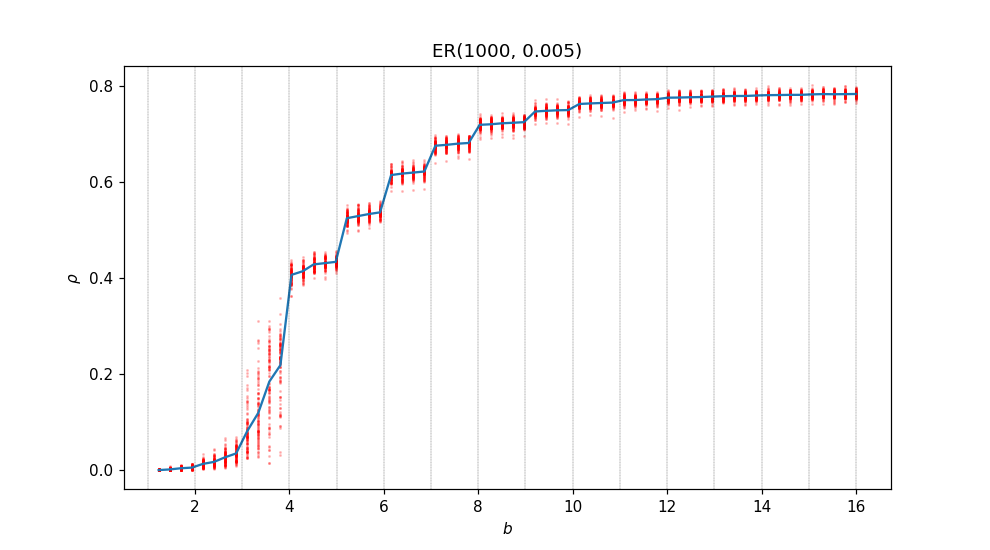

In [62]:
single(bs, 'single_fun_er_big', 1000, ['rho'], 'ER(1000, 0.005)')

In [8]:
def plot_2d(bs, filenames, last, keys, names, show_data=True):
    fig, grid = plt.subplots(nrows=2, ncols=3, figsize=(3 * 3, 2.5 * 2), sharex=True, sharey=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)
    plt.locator_params(axis='y', nbins=5)
    plt.locator_params(axis='x', nbins=10)
    
    for name, filename, s in zip(names, filenames, range(len(names))):
        with open(addr(filename), 'rb') as f:
            data = cut_alpha(pickle.load(f), 0)
        
        i = s // 3
        j = s % 3
        
        ax = grid[i][j]
        
        for key in keys:
            if key.startswith('std'):
                cur = np.apply_along_axis(np.std, 2, data[key[3:]][:, :, -last:])
            else:
                cur = np.apply_along_axis(np.mean, 2, data[key][:, :, -last:])
            if show_data:
                for t in cur:
                    ax.scatter(bs, t, s=1, alpha=.5, c='red')

            cur = np.apply_along_axis(np.mean, 0, cur)
            # cur = np.apply_along_axis(np.median, 0, cur)
            ax.plot(bs, cur, '-', label=f'{key}')
        # ax.legend()
        if j == 0:
            ax.set_ylabel(r'$\rho$')
        if i == 1:
            ax.set_xlabel(r'$b$')
        ax.set_title(name)

    plt.show()

In [9]:
def plot_of_prefix(prefix, draw):
    names = [prefix + suffix for suffix in ['_er', '_sf', '_ws', '_two', '_three', '_four']]
    plot_2d(bs, names, draw, ['rho'], ['ER', 'SF', 'WS', 'R2', 'R3', 'R4'])

In [10]:
def print_info(filename):
    with open(addr(filename), 'rb') as f:
            data = pickle.load(f)
            print(data['rho'].shape)

In [11]:
bs = partition(1, 16, 64)
alphas = [.1]
n = 1000
cnt = 100
print(bs)
print(alphas)

[ 1.234375  1.46875   1.703125  1.9375    2.171875  2.40625   2.640625
  2.875     3.109375  3.34375   3.578125  3.8125    4.046875  4.28125
  4.515625  4.75      4.984375  5.21875   5.453125  5.6875    5.921875
  6.15625   6.390625  6.625     6.859375  7.09375   7.328125  7.5625
  7.796875  8.03125   8.265625  8.5       8.734375  8.96875   9.203125
  9.4375    9.671875  9.90625  10.140625 10.375    10.609375 10.84375
 11.078125 11.3125   11.546875 11.78125  12.015625 12.25     12.484375
 12.71875  12.953125 13.1875   13.421875 13.65625  13.890625 14.125
 14.359375 14.59375  14.828125 15.0625   15.296875 15.53125  15.765625
 16.      ]
[0.1]


In [27]:
def ER(t):
    return ErdosRenyi(*t)

def SF(t):
    return ScaleFree(*t)

def WS(t):
    return SmallWorld(*t)

def er_graphs(cnt):
    for _ in range(cnt):
        yield ErdosRenyi(n, 5. / n)

def sf_graphs(cnt):
    for _ in range(cnt):
        yield ScaleFree(n, 5)

def ws_graphs(cnt):
    for _ in range(cnt):
        yield SmallWorld(n, 5, .5)
    
def r_graphs(cnt, degs):
    for _ in range(cnt):
        yield GraphByDegrees(degs)

In [70]:
def run_and_draw(name, fun, graphs, steps, draw, picname):
    timer = Timer()    
    calc(fun, alphas, bs, graphs, steps, name)
    print(f'overall time = {timer.measure() / 60} mins')
    single(bs, name, draw, ['rho'], picname)

time elapsed = 22324.179953813553
Written to /home/zhuk1996/data/single_fun_er_big.pkl
overall time = 372.13306479851406 mins


<IPython.core.display.Javascript object>


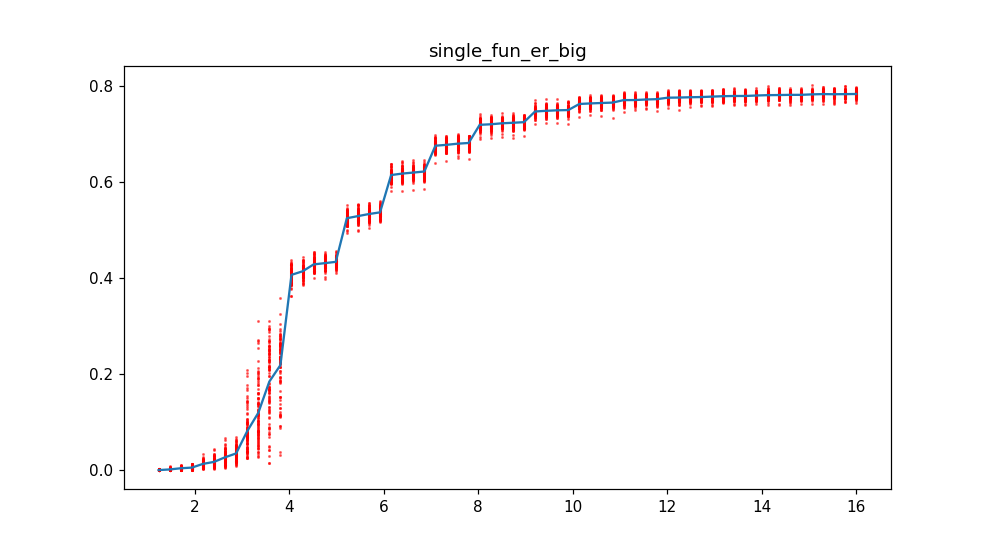

In [40]:
run_and_draw('single_fun_er_big', 'fun', er_graphs(100), 5000, 1000)

time elapsed = 909.4310007095337
Written to /home/zhuk1996/data/single_fun_r23.pkl
overall time = 15.177334475517274 mins


<IPython.core.display.Javascript object>


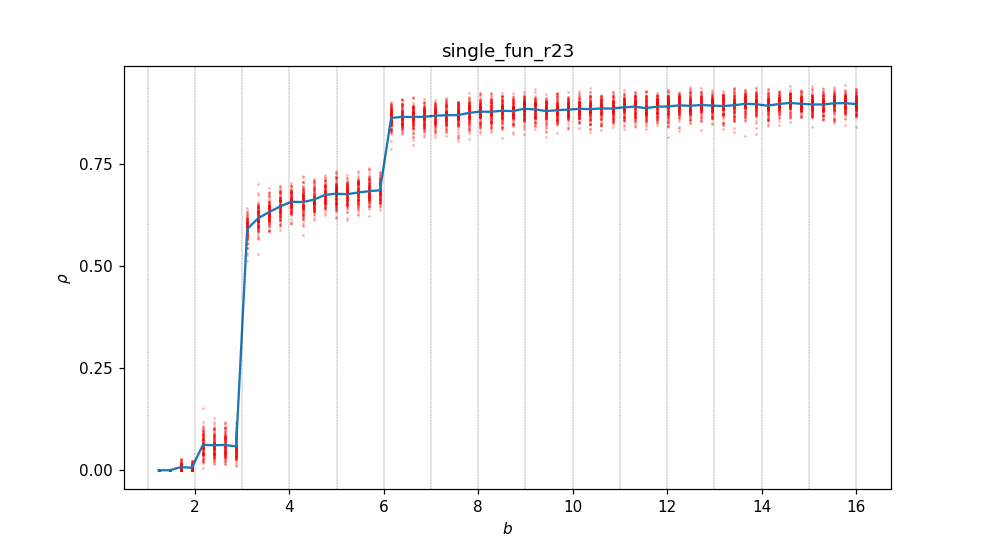

In [63]:
run_and_draw('single_fun_r23', 'fun', r_graphs(100, {2: 300, 3: 300}), 500, 100)

<IPython.core.display.Javascript object>


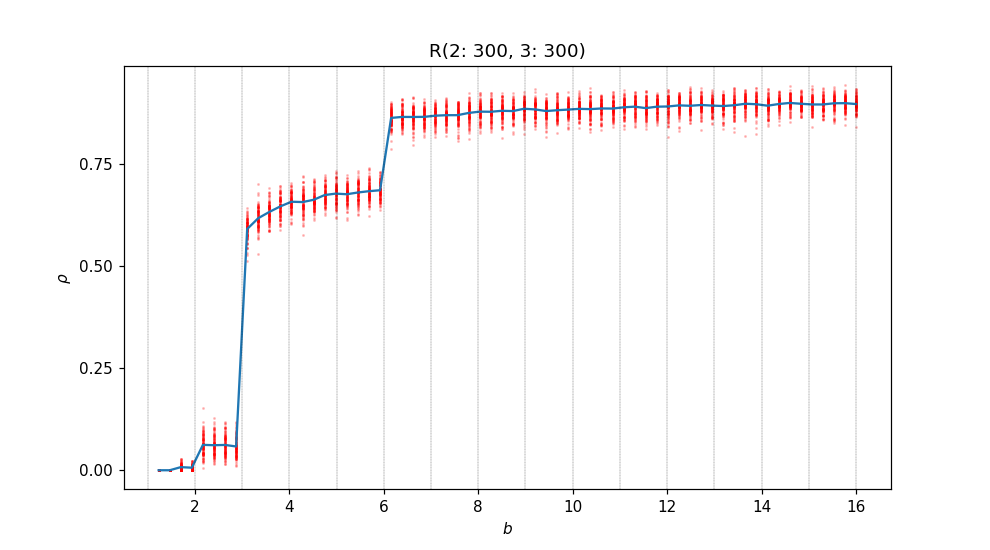

In [64]:
single(bs, 'single_fun_r23', 100, ['rho'], 'R(2: 300, 3: 300)')

time elapsed = 1291.635000705719
Written to /home/zhuk1996/data/single_fun_r24.pkl
overall time = 21.55880825916926 mins


<IPython.core.display.Javascript object>


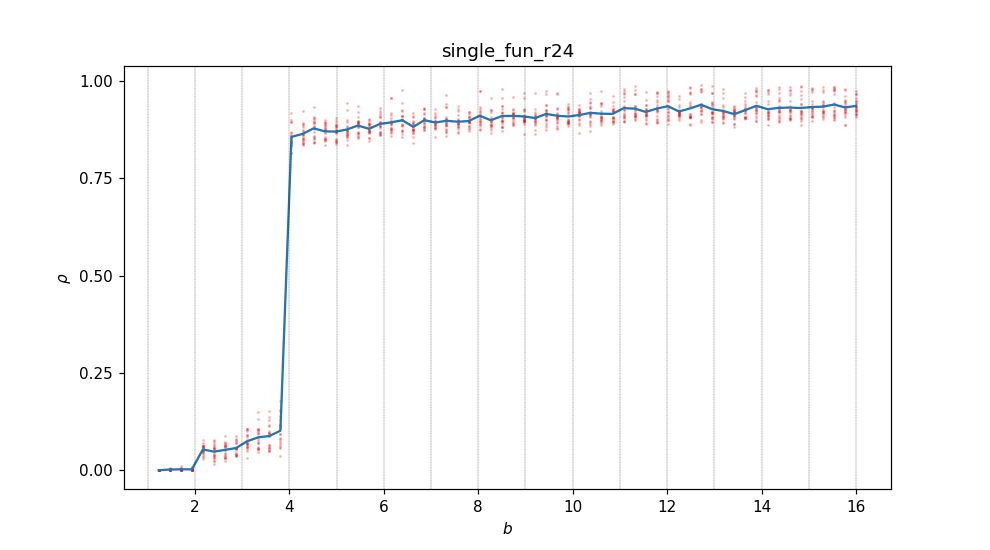

In [68]:
run_and_draw('single_fun_r24', 'fun', r_graphs(20, {2: 300, 4: 600}), 2000, 200)

<IPython.core.display.Javascript object>


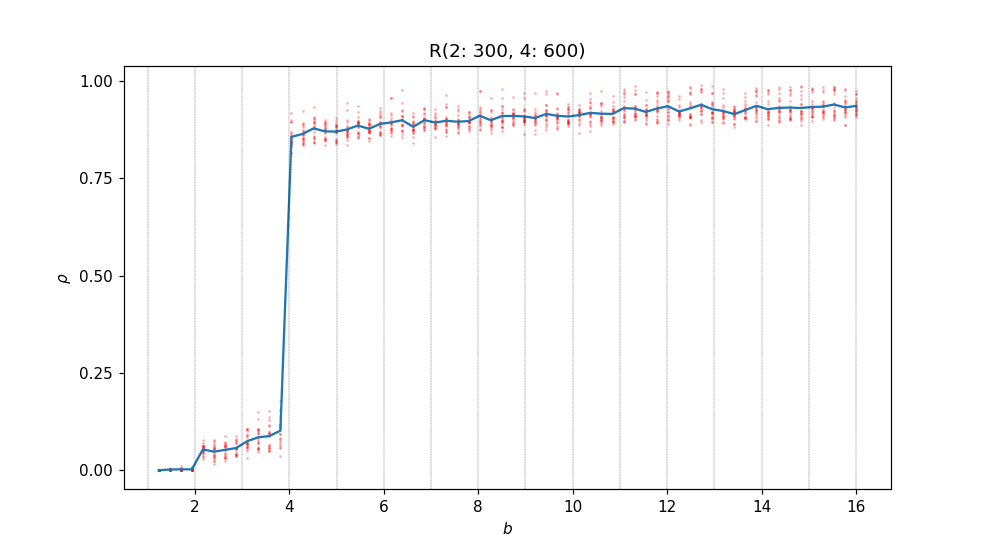

In [69]:
single(bs, 'single_fun_r24', 200, ['rho'], 'R(2: 300, 4: 600)')

time elapsed = 1870.017433166504
Written to /home/zhuk1996/data/single_fun_r35.pkl
overall time = 31.203229467074078 mins


<IPython.core.display.Javascript object>


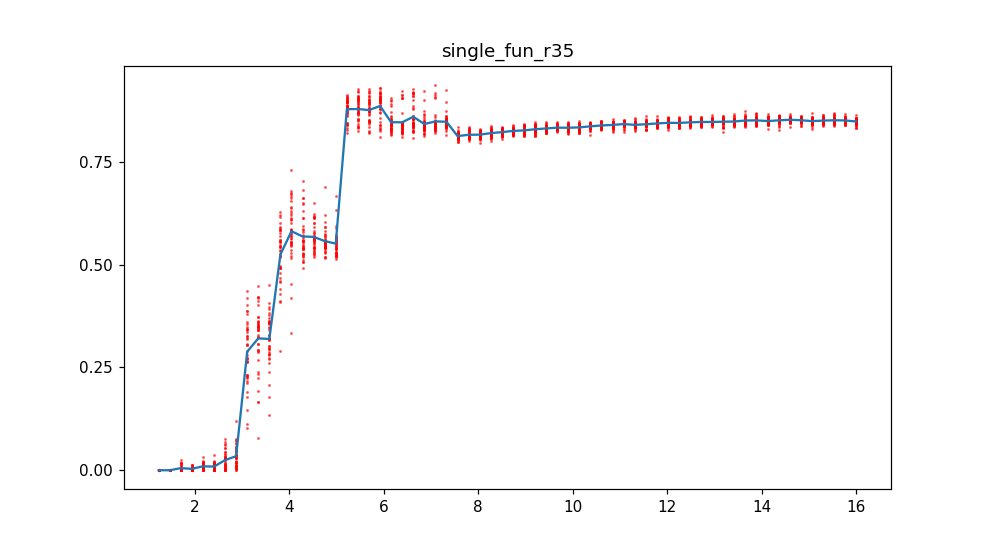

In [39]:
run_and_draw('single_fun_r35', 'fun', r_graphs(40, {3: 300, 5: 300}), 2000, 400)

<IPython.core.display.Javascript object>


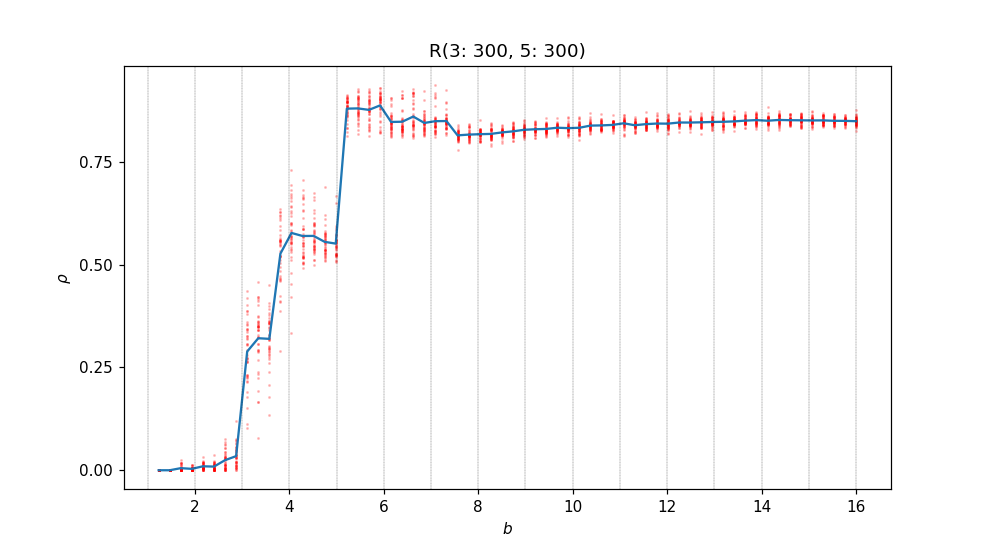

In [67]:
single(bs, 'single_fun_r35', 200, ['rho'], 'R(3: 300, 5: 300)')

<IPython.core.display.Javascript object>


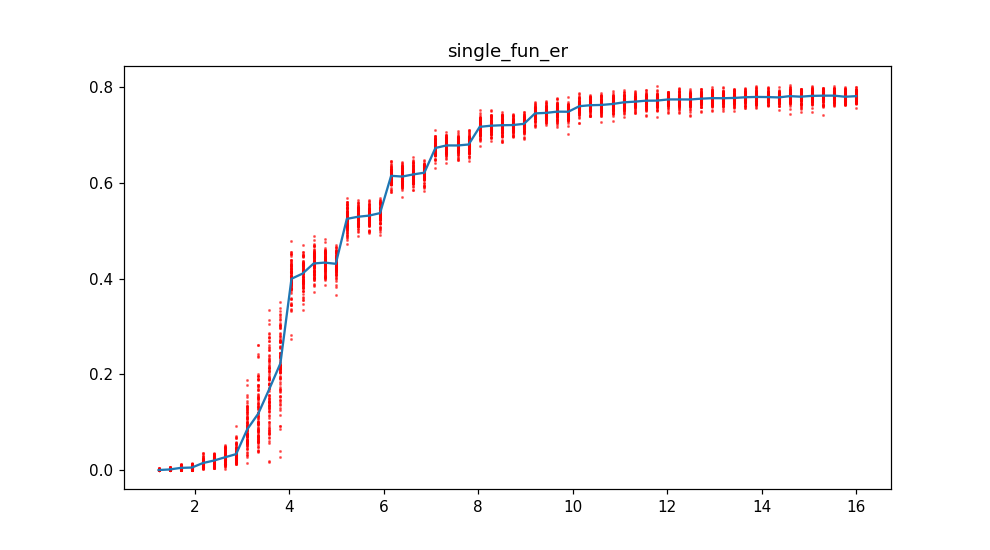

In [32]:
single(bs, 'single_fun_er', 100, ['rho'], 'single_fun_er')

time elapsed = 994.4214713573456
Written to /home/zhuk1996/data/single_fun_r26.pkl
overall time = 16.602934610843658 mins


<IPython.core.display.Javascript object>


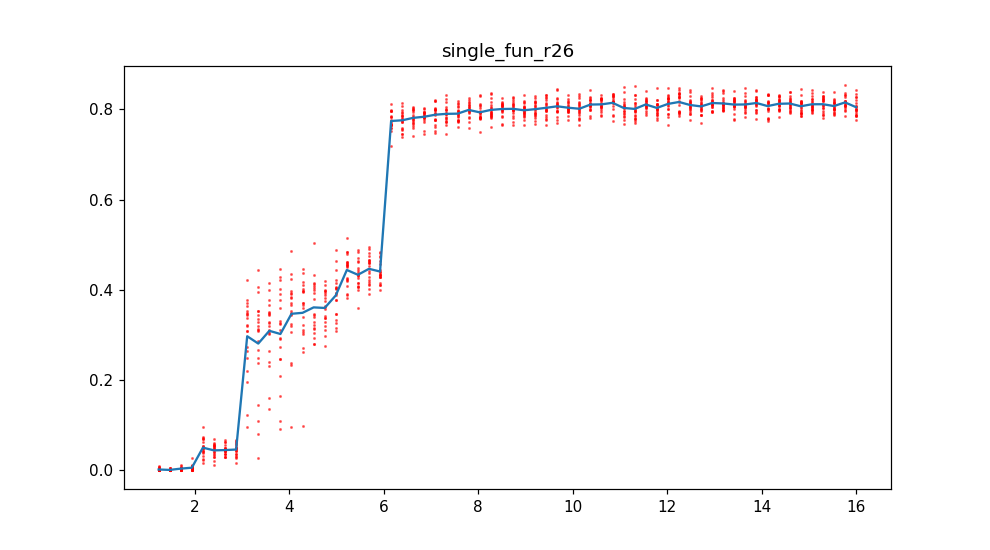

In [36]:
run_and_draw('single_fun_r26', 'fun', r_graphs(20, {2: 300, 6: 300}), 2000, 100)

<IPython.core.display.Javascript object>


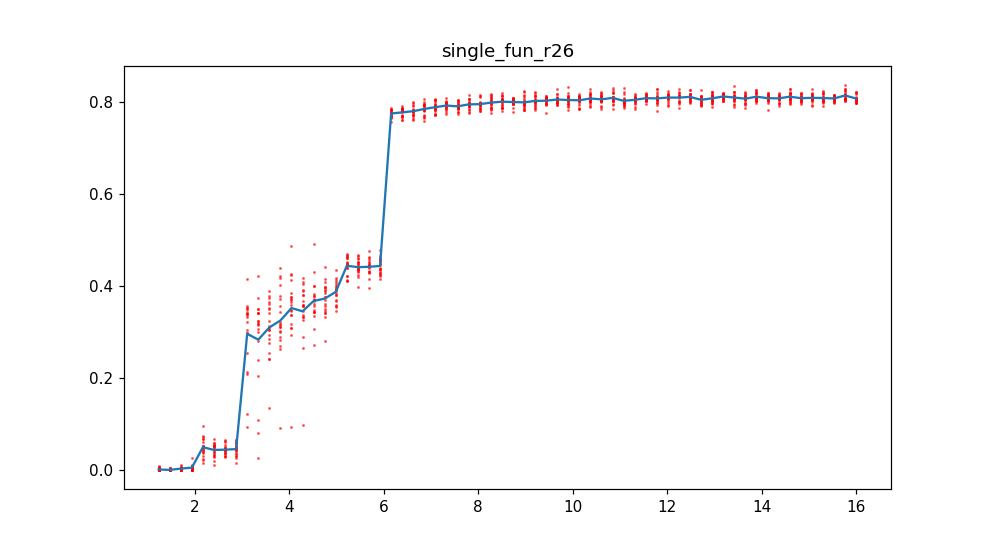

In [38]:
single(bs, 'single_fun_r26', 400, ['rho'], 'single_fun_r26')

time elapsed = 591.5554323196411
Written to /home/zhuk1996/data/single_fun_r357.pkl
overall time = 9.889513285954793 mins


<IPython.core.display.Javascript object>


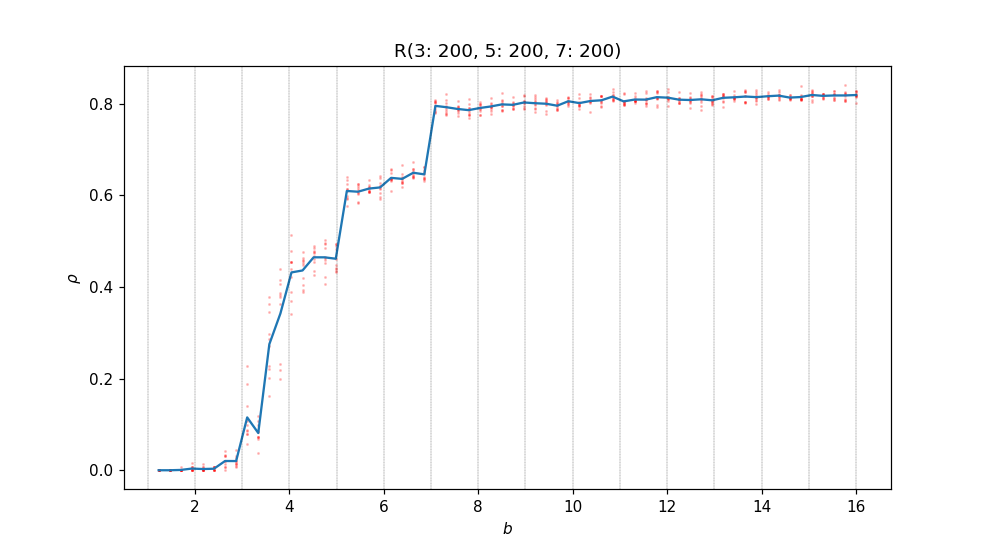

In [71]:
run_and_draw('single_fun_r357', 'fun', r_graphs(10, {3: 200, 5: 200, 7: 200}), 500, 100, 'R(3: 200, 5: 200, 7: 200)')

time elapsed = 365.7135112285614
Written to /home/zhuk1996/data/single_fun_sf.pkl
overall time = 6.1287582834561665 mins


<IPython.core.display.Javascript object>


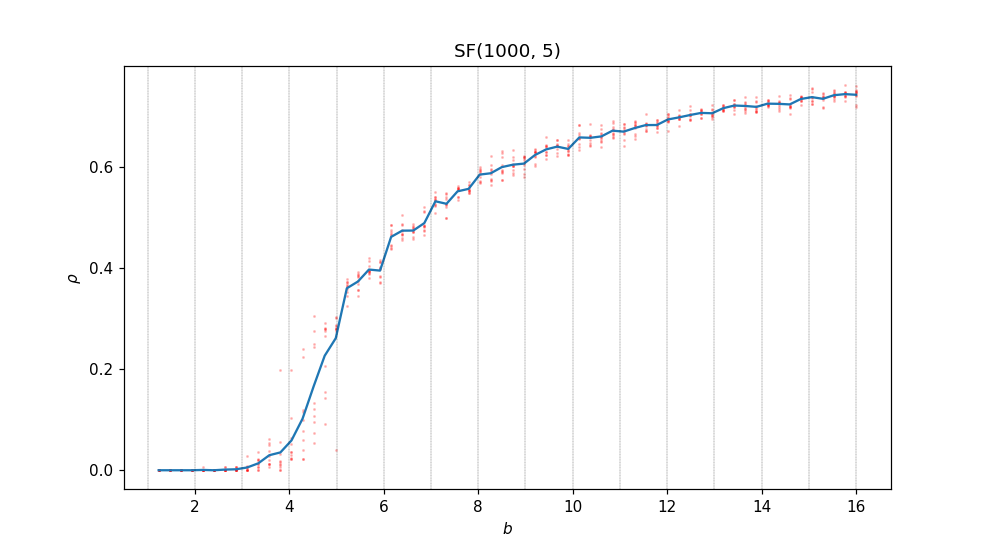

In [73]:
run_and_draw('single_fun_sf', 'fun', sf_graphs(10), 500, 100, 'SF(1000, 5)')